# Домашнее задание 2. Классификация изображений.

В этом задании потребуется обучить классификатор изображений. Будем работать с датасетом, название которого раскрывать не будем. Можете посмотреть самостоятельно на картинки, которые в есть датасете. В нём 200 классов и около 5 тысяч картинок на каждый класс. Классы пронумерованы, как нетрудно догадаться, от 0 до 199. Скачать датасет можно вот [тут](https://yadi.sk/d/BNR41Vu3y0c7qA).

Структура датасета простая -- есть директории train/ и val/, в которых лежат обучающие и валидационные данные. В train/ и val/ лежат директориии, соответствующие классам изображений, в которых лежат, собственно, сами изображения.
 
__Задание__. Необходимо выполнить любое из двух заданий

1) Добейтесь accuracy **на валидации не менее 0.44**. В этом задании **запрещено** пользоваться предобученными моделями и ресайзом картинок. 

2) Добейтесь accuracy **на валидации не менее 0.84**. В этом задании делать ресайз и использовать претрейн можно. 

Напишите краткий отчёт о проделанных экспериментах. Что сработало и что не сработало? Почему вы решили, сделать так, а не иначе? Обязательно указывайте ссылки на чужой код, если вы его используете. Обязательно ссылайтесь на статьи / блогпосты / вопросы на stackoverflow / видосы от ютуберов-машинлернеров / курсы / подсказки от Дяди Васи и прочие дополнительные материалы, если вы их используете. 

Ваш код обязательно должен проходить все `assert`'ы ниже.

Необходимо написать функции `train_one_epoch`, `train` и `predict` по шаблонам ниже (во многом повторяют примеры с семинаров).Обратите особое внимание на функцию `predict`: она должна возвращать список лоссов по всем объектам даталоадера, список предсказанных классов для каждого объекта из даталоалера и список настоящих классов для каждого объекта в даталоадере (и именно в таком порядке).

__Использовать внешние данные для обучения строго запрещено в обоих заданиях. Также запрещено обучаться на валидационной выборке__.


__Критерии оценки__: Оценка вычисляется по простой формуле: `min(10, 10 * Ваша accuracy / 0.44)` для первого задания и `min(10, 10 * (Ваша accuracy - 0.5) / 0.34)` для второго. Оценка округляется до десятых по арифметическим правилам. Если вы выполнили оба задания, то берется максимум из двух оценок.

__Бонус__. Вы получаете 5 бонусных баллов если справляетесь с обоими заданиями на 10 баллов (итого 15 баллов). В противном случае выставляется максимальная из двух оценок и ваш бонус равен нулю.

__Советы и указания__:
 - Наверняка вам потребуется много гуглить о классификации и о том, как заставить её работать. Это нормально, все гуглят. Но не забывайте, что нужно быть готовым за скатанный код отвечать :)
 - Используйте аугментации. Для этого пользуйтесь модулем `torchvision.transforms` или библиотекой [albumentations](https://github.com/albumentations-team/albumentations)
 - Можно обучать с нуля или файнтюнить (в зависимости от задания) модели из `torchvision`.
 - Рекомендуем написать вам сначала класс-датасет (или воспользоваться классом `ImageFolder`), который возвращает картинки и соответствующие им классы, а затем функции для трейна по шаблонам ниже. Однако делать это мы не заставляем. Если вам так неудобно, то можете писать код в удобном стиле. Однако учтите, что чрезмерное изменение нижеперечисленных шаблонов увеличит количество вопросов к вашему коду и повысит вероятность вызова на защиту :)
 - Валидируйте. Трекайте ошибки как можно раньше, чтобы не тратить время впустую.
 - Чтобы быстро отладить код, пробуйте обучаться на маленькой части датасета (скажем, 5-10 картинок просто чтобы убедиться что код запускается). Когда вы поняли, что смогли всё отдебажить, переходите обучению по всему датасету
 - На каждый запуск делайте ровно одно изменение в модели/аугментации/оптимайзере, чтобы понять, что и как влияет на результат.
 - Фиксируйте random seed.
 - Начинайте с простых моделей и постепенно переходите к сложным. Обучение лёгких моделей экономит много времени.
 - Ставьте расписание на learning rate. Уменьшайте его, когда лосс на валидации перестаёт убывать.
 - Советуем использовать GPU. Если у вас его нет, используйте google colab. Если вам неудобно его использовать на постоянной основе, напишите и отладьте весь код локально на CPU, а затем запустите уже написанный ноутбук в колабе. Авторское решение задания достигает требуемой точности в колабе за 15 минут обучения.
 
Good luck & have fun! :)

In [3]:
import numpy as np
import torch
import torchvision
import tqdm
from torch import nn
from torch.nn import functional as F
from sklearn.metrics import accuracy_score
# You may add any imports you need
from torch.optim import lr_scheduler
import glob
import matplotlib.pyplot as plt
from torchvision.datasets import ImageFolder
import sys
import warnings
from tqdm.auto import tqdm
from torchvision.models import resnet18
import random

In [1]:
def set_random_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

In [4]:
set_random_seed(666)

### Подготовка данных

In [5]:
!wget -O dataset.zip https://www.dropbox.com/s/33l8lp62rmvtx40/dataset.zip..
!unzip -qq dataset.zip -d dataset

--2021-11-21 16:50:58--  https://www.dropbox.com/s/33l8lp62rmvtx40/dataset.zip..
Resolving www.dropbox.com (www.dropbox.com)... 162.125.81.18, 2620:100:6035:18::a27d:5512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.81.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/33l8lp62rmvtx40/dataset.zip.. [following]
--2021-11-21 16:50:58--  https://www.dropbox.com/s/raw/33l8lp62rmvtx40/dataset.zip..
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucfaf8ecad04ab2b8f9a9aa33fc5.dl.dropboxusercontent.com/cd/0/inline/BaZtWxChgqUz2hSP-jrPSErJSuX6uoq_ZbodPqf0Ani-Y_YeyYqoVjYFLrQvdSIc4N-rI6O9DaMb4wrHBlt6BceO7K4sHROto1z7qJ8BqapsSIhLGmaxOYCy3hd98pwhTQsXmO1jX4WISRhsScajlfwt/file# [following]
--2021-11-21 16:50:59--  https://ucfaf8ecad04ab2b8f9a9aa33fc5.dl.dropboxusercontent.com/cd/0/inline/BaZtWxChgqUz2hSP-jrPSErJSuX6uoq_ZbodPqf0Ani-Y_YeyYqoVjYFLrQvdSIc4N-rI6O9DaMb4wrHBlt6

In [6]:
# YOU CAN DEFINE AUGMENTATIONS HERE
from torchvision.transforms import Compose, Normalize, Resize, ToTensor, RandomCrop, ColorJitter, RandomHorizontalFlip, RandomRotation, CenterCrop, RandomResizedCrop, RandomVerticalFlip

train_dataset = ImageFolder(
    "./dataset/dataset/dataset/train", 
    transform=Compose(
        [
            RandomHorizontalFlip(),
            RandomVerticalFlip(),
            RandomRotation(degrees=30),
            ColorJitter(hue=.05, saturation=.05),
            ToTensor(),
            Normalize((0.5, 0.5, 0.5), (1, 1, 1)), 
        ]
    )
)
val_dataset = ImageFolder(
    "./dataset/dataset/dataset/val", 
    transform=Compose(
        [
            ToTensor(),
            Normalize((0.5, 0.5, 0.5), (1, 1, 1)), 
        ]
    )
)
# REPLACE ./dataset/dataset WITH THE FOLDER WHERE YOU DOWNLOADED AND UNZIPPED THE DATASET
# OR USE torchvision.datasets.ImageFolder INSTEAD OF MyDataset

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=256, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=256, shuffle=False)

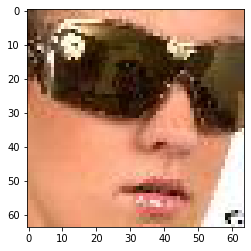

In [50]:
# Посмотрю на рандомную картинку

file = np.random.choice(glob.glob("./dataset/dataset/dataset/train/*/*.jpg"))
plt.imshow(plt.imread(file));

In [8]:
# Just very simple sanity checks
assert isinstance(train_dataset[0], tuple)
assert len(train_dataset[0]) == 2
assert isinstance(train_dataset[1][1], int)
print("tests passed")

tests passed


### Вспомогательные функции, реализация модели

In [9]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device

'cuda:0'

In [20]:
def train_one_epoch(model, train_dataloader, criterion, optimizer, device):
    model.train()
    # YOUR CODE
    # TRAIN YOUR MODEL HERE
    total_loss = 0
    num_batches = 0
    all_losses = []
    total_predictions = np.array([])#.reshape((0, ))
    total_labels = np.array([])#.reshape((0, ))
    with tqdm(total=len(train_dataloader), file=sys.stdout) as prbar:
        for images, labels in train_dataloader:
            # Move Batch to GPU
            images = images.to(device)
            labels = labels.to(device)
            predicted = model(images)
            loss = criterion(predicted, labels)
            # Update weights
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            # Update descirption for tqdm
            accuracy = (predicted.argmax(1) == labels).float().mean()
            prbar.set_description(
                f"Loss: {round(loss.item(), 4)} "
                f"Accuracy: {round(accuracy.item(), 4)}"
            )
            prbar.update(1)
            total_loss += loss.item()
            total_predictions = np.append(total_predictions, predicted.argmax(1).cpu().detach().numpy())
            total_labels = np.append(total_labels, labels.cpu().detach().numpy())
            num_batches += 1
            all_losses.append(loss.detach().item())
    metrics = {"loss": total_loss / num_batches}
    metrics.update({"accuracy": (total_predictions == total_labels).mean()})
    return metrics, all_losses


def predict(model, val_dataloder, criterion, device):
    model.eval()
    # YOUR CODE
    # PREDICT FOR EVERY ELEMENT OF THE VAL DATALOADER AND RETURN CORRESPONDING LISTS

    total_loss = 0
    num_batches = 0
    total_predictions = np.array([])
    total_labels = np.array([])
    with tqdm(total=len(val_dataloader), file=sys.stdout) as prbar:
        for images, labels in val_dataloader:
            images = images.to(device)
            labels = labels.to(device)
            predicted = model(images)
            loss = criterion(predicted, labels)
            accuracy = (predicted.argmax(1) == labels).float().mean()
            prbar.set_description(
                f"Loss: {round(loss.item(), 4)} "
                f"Accuracy: {round(accuracy.item(), 4)}"
            )
            prbar.update(1)
            total_loss += loss.item()
            total_predictions = np.append(total_predictions, predicted.argmax(1).cpu().detach().numpy())
            total_labels = np.append(total_labels, labels.cpu().detach().numpy())
            num_batches += 1
    metrics = {"loss": total_loss / num_batches}
    metrics.update({"accuracy": (total_predictions == total_labels).mean()})
    return total_loss, total_predictions, total_labels, metrics


def train(model, train_dataloader, val_dataloader, criterion, optimizer, device, n_epochs, scheduler):

    all_train_losses = []
    epoch_train_losses = []
    epoch_eval_losses = []

    for epoch in range(n_epochs):
        # YOUR CODE
        # Train, evaluate, print accuracy, make a step of scheduler or whatever you want...

        # Train step
        print(f"Train Epoch: {epoch}")
        train_metrics, one_epoch_train_losses = train_one_epoch(
            model=model,
            train_dataloader=train_dataloader,
            criterion=criterion,
            optimizer=optimizer,
            device=device
        )
        # Save Train losses
        all_train_losses.extend(one_epoch_train_losses)
        epoch_train_losses.append(train_metrics["loss"])
        # Eval step
        print(f"Validation Epoch: {epoch}")
        with torch.no_grad():
            n1, n2, n3, validation_metrics = predict(
                model=model, 
                val_dataloder=val_dataloader, 
                criterion=criterion, 
                device=device
                )
        # Save eval losses
        epoch_eval_losses.append(validation_metrics["loss"])
        scheduler.step(validation_metrics["loss"])
    # Visualization
    epochs = range(n_epochs)
    plt.plot(epochs, epoch_train_losses, label="train")
    plt.plot(epochs, epoch_eval_losses, label="val")
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.legend()
    plt.show()


### Обучение модели, запуски экспериментов

In [24]:
model = resnet18(pretrained=False)
model.fc = nn.Linear(512, 200)
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), 1e-3)
criterion = nn.CrossEntropyLoss()
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, threshold=0.01)
n_epochs = 20

Простой тест на проверку правильности написанного кода

In [15]:
all_losses, predicted_labels, true_labels, metrics_global = predict(model, val_dataloader, criterion, device)
assert len(predicted_labels) == len(val_dataset)
accuracy = accuracy_score(predicted_labels, true_labels)
print("tests passed")

  0%|          | 0/40 [00:00<?, ?it/s]

tests passed


Запустить обучение можно в ячейке ниже.

Train Epoch: 0


  0%|          | 0/391 [00:00<?, ?it/s]

Validation Epoch: 0


  0%|          | 0/40 [00:00<?, ?it/s]

Train Epoch: 1


  0%|          | 0/391 [00:00<?, ?it/s]

Validation Epoch: 1


  0%|          | 0/40 [00:00<?, ?it/s]

Train Epoch: 2


  0%|          | 0/391 [00:00<?, ?it/s]

Validation Epoch: 2


  0%|          | 0/40 [00:00<?, ?it/s]

Train Epoch: 3


  0%|          | 0/391 [00:00<?, ?it/s]

Validation Epoch: 3


  0%|          | 0/40 [00:00<?, ?it/s]

Train Epoch: 4


  0%|          | 0/391 [00:00<?, ?it/s]

Validation Epoch: 4


  0%|          | 0/40 [00:00<?, ?it/s]

Train Epoch: 5


  0%|          | 0/391 [00:00<?, ?it/s]

Validation Epoch: 5


  0%|          | 0/40 [00:00<?, ?it/s]

Train Epoch: 6


  0%|          | 0/391 [00:00<?, ?it/s]

Validation Epoch: 6


  0%|          | 0/40 [00:00<?, ?it/s]

Train Epoch: 7


  0%|          | 0/391 [00:00<?, ?it/s]

Validation Epoch: 7


  0%|          | 0/40 [00:00<?, ?it/s]

Train Epoch: 8


  0%|          | 0/391 [00:00<?, ?it/s]

Validation Epoch: 8


  0%|          | 0/40 [00:00<?, ?it/s]

Train Epoch: 9


  0%|          | 0/391 [00:00<?, ?it/s]

Validation Epoch: 9


  0%|          | 0/40 [00:00<?, ?it/s]

Train Epoch: 10


  0%|          | 0/391 [00:00<?, ?it/s]

Validation Epoch: 10


  0%|          | 0/40 [00:00<?, ?it/s]

Train Epoch: 11


  0%|          | 0/391 [00:00<?, ?it/s]

Validation Epoch: 11


  0%|          | 0/40 [00:00<?, ?it/s]

Train Epoch: 12


  0%|          | 0/391 [00:00<?, ?it/s]

Validation Epoch: 12


  0%|          | 0/40 [00:00<?, ?it/s]

Train Epoch: 13


  0%|          | 0/391 [00:00<?, ?it/s]

Validation Epoch: 13


  0%|          | 0/40 [00:00<?, ?it/s]

Train Epoch: 14


  0%|          | 0/391 [00:00<?, ?it/s]

Validation Epoch: 14


  0%|          | 0/40 [00:00<?, ?it/s]

Train Epoch: 15


  0%|          | 0/391 [00:00<?, ?it/s]

Validation Epoch: 15


  0%|          | 0/40 [00:00<?, ?it/s]

Train Epoch: 16


  0%|          | 0/391 [00:00<?, ?it/s]

Validation Epoch: 16


  0%|          | 0/40 [00:00<?, ?it/s]

Train Epoch: 17


  0%|          | 0/391 [00:00<?, ?it/s]

Validation Epoch: 17


  0%|          | 0/40 [00:00<?, ?it/s]

Train Epoch: 18


  0%|          | 0/391 [00:00<?, ?it/s]

Validation Epoch: 18


  0%|          | 0/40 [00:00<?, ?it/s]

Train Epoch: 19


  0%|          | 0/391 [00:00<?, ?it/s]

Validation Epoch: 19


  0%|          | 0/40 [00:00<?, ?it/s]

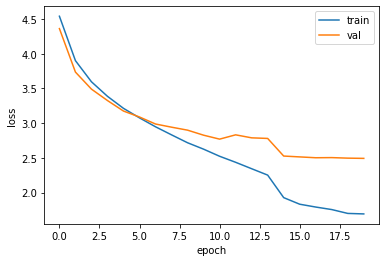

In [25]:
train(model, train_dataloader, val_dataloader, criterion, optimizer, device, n_epochs, scheduler)

### Проверка полученной accuracy

После всех экспериментов которые вы проделали, выберите лучшую из своих моделей, реализуйте и запустите функцию `evaluate`. Эта функция должна брать на вход модель и даталоадер с валидационными данными и возврашать accuracy, посчитанную на этом датасете.

In [26]:
all_losses, predicted_labels, true_labels, metrics_global = predict(model, val_dataloader, criterion, device)
assert len(predicted_labels) == len(val_dataset)
accuracy = accuracy_score(true_labels, predicted_labels)
print(accuracy)
print("Оценка за это задание составит {} баллов".format(min(10, 10 * accuracy / 0.44)))

  0%|          | 0/40 [00:00<?, ?it/s]

0.4165
Оценка за это задание составит 9.465909090909092 баллов


### Отчёт об экспериментах 

Проводилось ОЧЕНЬ много экспериментов, и было просмотрено ОЧЕНЬ много сайтов с документацией или просто сайтов о классификации картинок с помощью нейронных сетей. 
В общем и целом, вся суть экспериментов состояла в подборе лучшего размера батча, лучшего learning rate, лучшего optimizer и scheduler. Отдельно стоит отметить эксперименты с аугментациями. Там были еще те вечеринки..
Очень помогла визуализация лосса и подсчет accuracy на каждой эпохе трейна и валидации. То есть, с помощью них удобно было смотреть, что улучшает модель, а что ее только портит. 
Я почти сошла с ума с этой домашкой, но безумно счастлива, что хоть чего-то добилась. Ура!!!!!!!!!!!